In [1]:

##########################################################
# Content:
# part I:   Install and import packages and load data
# part II:  Pre-process and vectorize the documents
# Part III: Training LDA model
# Part IV:  Find the optimal number of topics using coherence_values
# Part V:   Compute similarity of topics 
# Part VI:  Visualize the topics




In [2]:
##########################################################

##########################################################

# Part I: install and import packages and load data  

##########################################################
# please install these modules before you run the code:
!pip install gensim

!pip install nltk
#!pip install matplotlib


In [3]:

import os
import re
import pandas as pd
## `nltk.download('punkt')
import numpy as np

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
import nltk
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.matutils import kullback_leibler, jaccard, hellinger, sparse2full
#from gensim.test.utils import common_corpus
from gensim.models import LdaModel
from gensim.test.utils import datapath
#from gensim.models import LdaSeqModel
#from gensim.corpora import Dictionary, bleicorpus
#from gensim import models, similarities

# spacy for lemmatization
import spacy
from scipy.stats import wasserstein_distance

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import matplotlib.pyplot as plt
from collections import  defaultdict
from pprint import pprint


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielpele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
############################
# Please change the working directory to your path!
# os.chdir("/Users/xinwenni/LDA-DTM/DTM") 
############################

# load data


path_datasets="/Users/danielpele/Library/CloudStorage/GoogleDrive-danpele@ase.ro/Other \
computers/Asus/G/PROIECTE/Understanding Digital Assets/Cod/Datasets/"
# load data
df = pd.read_csv(path_datasets+"posts.csv", low_memory=False)
df.head()


,date,Unnamed: 0,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,...,Overperforming Score,sentiment_positive,sentiment_negative,sentiment_neutral,year,predominant_sentiment,compound_sentiment,sentiment_intensity,final_sentiment_score,compound
0,2017-01-27 23:07:20,0,Cheat Codes ATL,cheatcodesatlanta,1.000000e+14,ORG_GENERAL,US,Cheat Codes is a media company that empowers p...,25/01/2017 02:20,NaN,...,"4,283.59",0.051737,0.022936,0.925327,2017,sentiment_neutral,0.028801,14.984698,15.013499,0.028801
1,2017-12-17 00:01:18,1,Batdad,BatDadOfficial,1.000000e+14,DIGITAL_CREATOR,US,I'm BatDad,25/09/2013 01:30,6857356.0,...,184.31,0.043961,0.015284,0.940754,2013,sentiment_neutral,0.028677,13.593631,13.622308,0.028677
2,2017-12-17 02:06:24,2,John-Paul Ugwu,jpaulugwu2,1.000000e+14,PERSONAL_BLOG,NG,We are news Network,14/12/2017 12:27,NaN,...,"2,790.59",0.038404,0.225466,0.736130,2017,sentiment_neutral,-0.187062,6.258647,6.071585,-0.187062
3,2017-07-01 19:46:35,3,Bitcoin & Crypto,bitcoinandcrypto,1.000000e+14,ACTIVITY_GENERAL,US,Bringing you the latest news and analyses on t...,05/06/2017 19:19,NaN,...,251.8,0.040747,0.030607,0.928647,2017,sentiment_neutral,0.010140,10.901994,10.912135,0.010140
4,2017-12-22 05:56:21,4,LoanCoin,LoanCoin2017,1.000000e+14,TOPIC_BUSINESS_SERVICES,TH,"LOANCOIN has designed an advanced ""loan system...",02/12/2017 11:19,176368.0,...,39.22,0.090149,0.070592,0.839259,2017,sentiment_neutral,0.019557,5.525476,5.545033,0.019557


In [5]:
df[['Message']]

,Message
0,180 seconds of basic economics explained perfe...
1,Bitcoin Insta - batdadblake
2,Today is the saddest day of my life. As a Doct...
3,"Well people can stop saying ""What can you buy ..."
4,"Dear Investors, 1) Please do not share your pe..."
...,...
82805,"Bitcoin ATM scams are on the rise, and scammer..."
82806,Leaving coinbase... but staying in crypto #fin...
82807,"At AES, our main value is Safety first. Here's..."
82808,Want to accept Bitcoin and Ethereum tips on Tw...


In [6]:

##########################################################

# Part II: Pre-process and vectorize the documents

##########################################################

# Convert the 'Message' column to a list
data = df['Message'].values.tolist()
data = [str(item) for item in data]

def clean_data(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    pprint(data[:1])
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def get_lemm(data):
    data_words = list(sent_to_words(data))
#    print(data_words[:1])
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # See trigram example
#    print(trigram_mod[bigram_mod[data_words[0]]])
    
    # Remove Stop Words
    data_words_nostops=remove_stopwords(data_words)

    # Form Bigrams
#    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    #data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
#    print(data_lemmatized[:1])
    return data_lemmatized

# simple clean the data first 
data=clean_data(data)
# define stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use','also'])
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Tokenize and lemmatize data 
data_lemmatized=get_lemm(data)

# Create Dictionary
id2word= corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#Let’s see how many tokens and documents we have to train on.
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))



<>:13: DeprecationWarning: invalid escape sequence '\S'
<>:16: DeprecationWarning: invalid escape sequence '\s'
<>:13: DeprecationWarning: invalid escape sequence '\S'
<>:16: DeprecationWarning: invalid escape sequence '\s'
/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_10224/3450740866.py:13: DeprecationWarning: invalid escape sequence '\S'
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_10224/3450740866.py:16: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', sent) for sent in data]


['180 seconds of basic economics explained perfectly! Get $10 in Bitcoin FREE '
 'when you invest $100 (click our affiliate link): '
 'http://bit.ly/coinbasesign:=:https://www.coinbase.com/join/59e80734c90f890144c1f448 '
 'Inbox us if you would like anything posted on our page‼️ 👌🏾👌🏾💯💯✔️ Credit: '
 'Sean Shewmake (aka "Tommy Bottoms")']
Number of unique tokens: 61050
Number of documents: 82810


In [7]:
##########################################################

# Part III: Training LDA model 

##########################################################

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
#
## Make a index to word dictionary.
#temp = dictionary[0]  # This is only to "load" the dictionary.
#id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(top_topics)



Average topic coherence: -3.9746.
[([(0.020181447, 'make'),
   (0.018413574, 'go'),
   (0.01518372, 'take'),
   (0.013419408, 'good'),
   (0.011706618, 'time'),
   (0.01151885, 'know'),
   (0.011316123, 'people'),
   (0.010697063, 'say'),
   (0.010626091, 'get'),
   (0.010566405, 'come'),
   (0.009906531, 'see'),
   (0.009744695, 'give'),
   (0.009674057, 'work'),
   (0.009509773, 'money'),
   (0.008880937, 'well'),
   (0.008797948, 'day'),
   (0.008703504, 'year'),
   (0.008419812, 'need'),
   (0.007819667, 'find'),
   (0.0077633373, 'want')],
  -1.8612245346909349),
 ([(0.019159283, 'crypto'),
   (0.015851066, 'cryptocurrency'),
   (0.011042355, 'investment'),
   (0.0095602665, 'currency'),
   (0.008926554, 'trading'),
   (0.00882651, 'blockchain'),
   (0.008718963, 'exchange'),
   (0.008635092, 'financial'),
   (0.008536999, 'asset'),
   (0.0081266435, 'new'),
   (0.007944435, 'digital'),
   (0.0076372563, 'company'),
   (0.0072094332, 'future'),
   (0.0071042445, 'invest'),
   (0.0

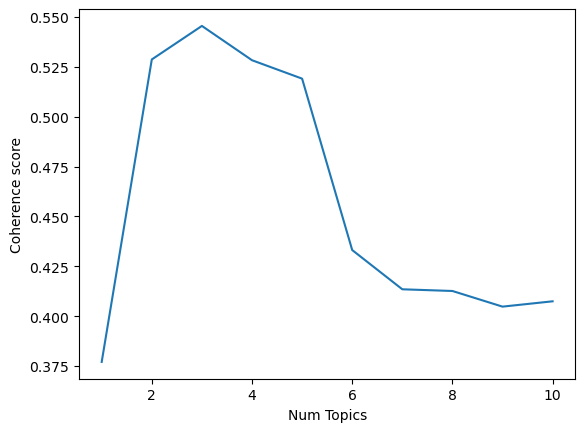

In [8]:

##########################################################

# Part IV: find the optimal number of topics using coherence_values

##########################################################
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel( corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=11, step=1)

# Show graph
filename='Num_Topic_CV'
limit=11; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
#plt.ylim([0.25,0.45])
#plt.legend(("coherence_values"), loc='best')
plt.savefig(filename,dpi = 720,transparent=True)
plt.show()



In [9]:

# optimal number is 11, then adjust the topic number, and retrain the LDA model 
num_topic=5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)


lda_model.show_topics()

# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(0,10))
doc_lda = lda_model[corpus]
 

[(1,
  '0.026*"card" + 0.021*"call" + 0.016*"payment" + 0.016*"credit" + '
  '0.015*"contact" + 0.015*"address" + 0.014*"gift" + 0.013*"online" + '
  '0.012*"coin" + 0.012*"office"'),
 (2,
  '0.151*"com" + 0.052*"https" + 0.032*"referral" + 0.017*"app" + 0.016*"www" '
  '+ 0.016*"link" + 0.015*"affiliate" + 0.015*"video" + 0.015*"patreon" + '
  '0.015*"bitrue"'),
 (3,
  '0.018*"game" + 0.012*"right" + 0.007*"go" + 0.007*"self" + 0.006*"old" + '
  '0.006*"instrumental" + 0.006*"play" + 0.006*"join" + 0.006*"support" + '
  '0.006*"song"'),
 (4,
  '0.053*"bitcoin" + 0.029*"crypto" + 0.021*"trading" + 0.021*"price" + '
  '0.020*"market" + 0.012*"cryptocurrency" + 0.012*"beat" + 0.010*"day" + '
  '0.009*"trade" + 0.008*"stock"'),
 (0,
  '0.008*"investment" + 0.007*"blockchain" + 0.007*"currency" + 0.007*"asset" '
  '+ 0.006*"say" + 0.006*"future" + 0.006*"crypto" + 0.005*"make" + '
  '0.005*"include" + 0.005*"financial"')]


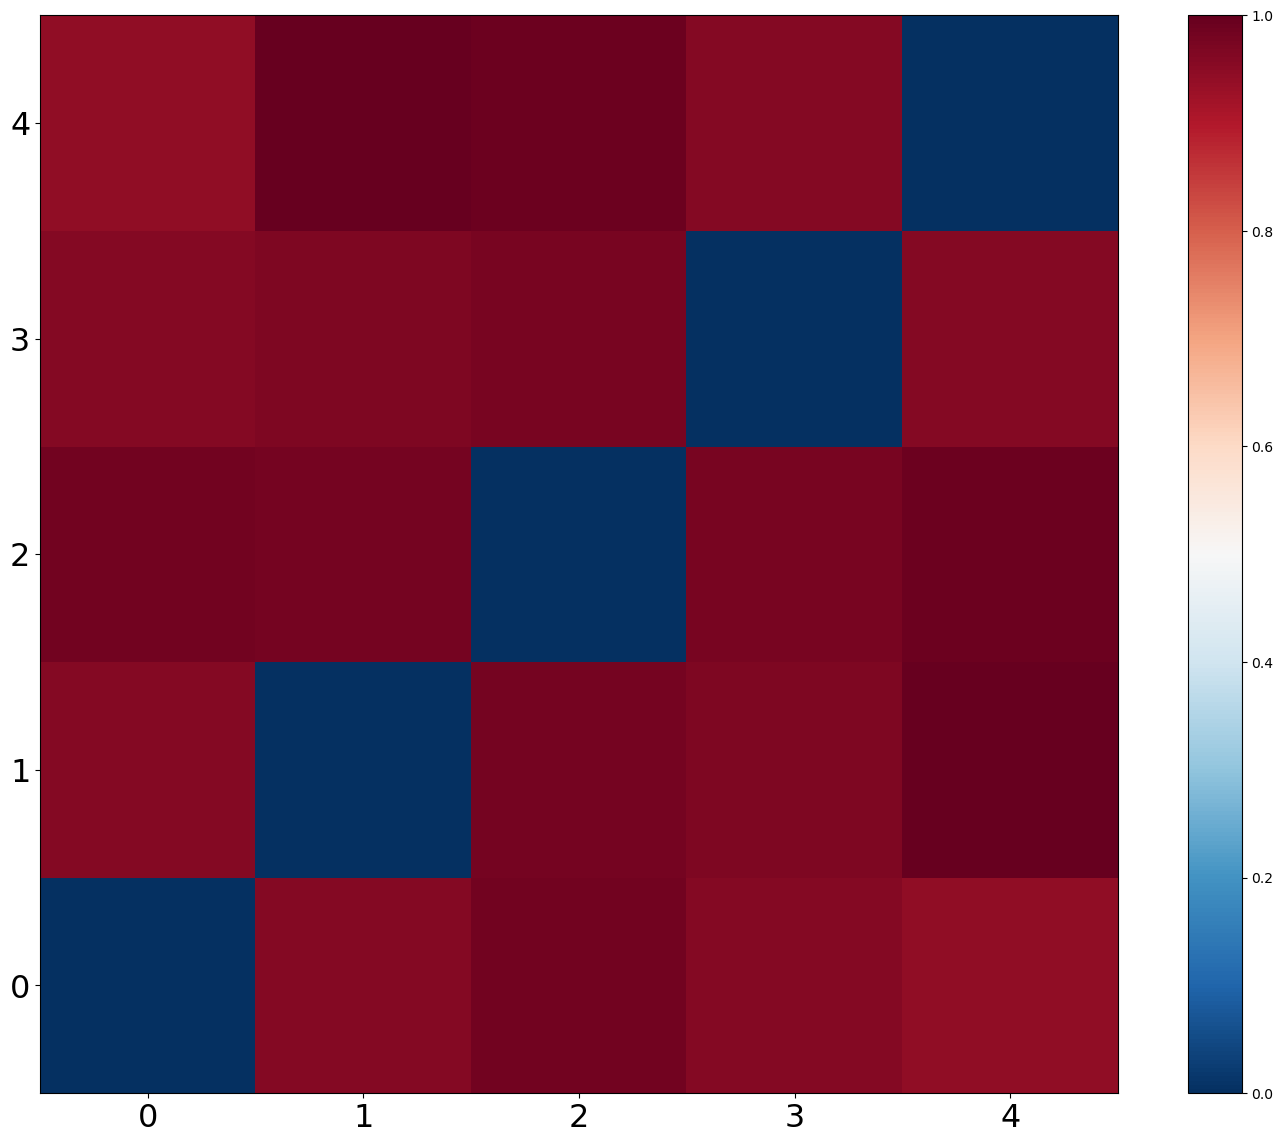

In [10]:
##########################################################

# Part V: Compute similarity of topics 

##########################################################

def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

plot_difference = plot_difference_matplotlib
'''
try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly
'''    
mdiff, annotation = lda_model.diff(lda_model, distance='hellinger', num_words=50)
plot_difference(mdiff,  annotation=annotation)
plt.tick_params(labelsize=23)
plt.savefig("topic_distance_H.png",dpi = 360,transparent=True)



In [11]:

##########################################################

# Part VI: Visualize the topics

##########################################################
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis
##########################################################

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.156555 -0.143304       1        1  40.400255
4      0.279909  0.060146       2        1  30.233571
3      0.025195  0.039127       3        1  13.565366
2     -0.204948  0.307500       4        1  10.957150
1     -0.256710 -0.263469       5        1   4.843658, topic_info=             Term          Freq         Total Category  logprob  loglift
7             com  40711.000000  40711.000000  Default  30.0000  30.0000
3         bitcoin  39871.000000  39871.000000  Default  29.0000  29.0000
14          https  13905.000000  13905.000000  Default  28.0000  28.0000
798      referral   8513.000000   8513.000000  Default  27.0000  27.0000
545        crypto  27181.000000  27181.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
327           pay   1242.713680   3837.295648   Topic5  -4.5608   1.

In [12]:
pyLDAvis.save_html(vis, '20231129 LDA_vis.html')

In [13]:
num_words = 10  # Number of words to extract for each topic

topic_words = []
for i in range(lda_model.num_topics):
    top_words = lda_model.show_topic(i, topn=num_words)
    topic_words.append([word for word, weight in top_words])


In [14]:
topic_words

[['investment',
  'blockchain',
  'currency',
  'asset',
  'say',
  'future',
  'crypto',
  'make',
  'include',
  'financial'],
 ['card',
  'call',
  'payment',
  'credit',
  'contact',
  'address',
  'gift',
  'online',
  'coin',
  'office'],
 ['com',
  'https',
  'referral',
  'app',
  'www',
  'link',
  'affiliate',
  'video',
  'patreon',
  'bitrue'],
 ['game',
  'right',
  'go',
  'self',
  'old',
  'instrumental',
  'play',
  'join',
  'support',
  'song'],
 ['bitcoin',
  'crypto',
  'trading',
  'price',
  'market',
  'cryptocurrency',
  'beat',
  'day',
  'trade',
  'stock']]

In [15]:
from Plot import print_coherence
from gensim import corpora




dictionary = corpora.Dictionary(data_lemmatized)

dic = dictionary
print_coherence(dic, topic_words,data_lemmatized)

Topic: investment,blockchain,currency,asset,say,futu	Coherence: 0.57
Topic: card,call,payment,credit,contact,address,gift	Coherence: 0.57
Topic: com,https,referral,app,www,link,affiliate,vid	Coherence: 0.72
Topic: game,right,go,self,old,instrumental,play,join	Coherence: 0.36
Topic: bitcoin,crypto,trading,price,market,cryptocur	Coherence: 0.57


In [16]:
import os
df_copy = df.copy()

# Calculate the topic proportions for each document
topic_proportions = model.get_document_topics(corpus, minimum_probability=0.0)

# Add the topic proportions to the DataFrame
for i, topic in enumerate(topic_words):
    topic_name = str(','.join(topic[:4]))
    df_copy[topic_name] = [doc_topic[i][1] for doc_topic in topic_proportions]
    



In [17]:
import pandas as pd
import numpy as np

# Assuming df_copy is your original DataFrame
# Convert 'date' column to datetime with dayfirst=True if the format is dd/mm/yyyy
df_copy['date'] = pd.to_datetime(df_copy['Page Created'], dayfirst=True)

# Convert the index of df to a DatetimeIndex
df_copy.index = pd.to_datetime(df_copy['date'])

# Filter dates after 2012
df_copy = df_copy[df_copy.index >= '2012-01-01']

# Create 'year-month' column for grouping
df_copy['year-month'] = df_copy.index.to_period('M')

# Select only numeric columns for mean calculation
numeric_df = df_copy.select_dtypes(include=[np.number])

# Add 'year-month' column to numeric_df for grouping
numeric_df['year-month'] = df_copy['year-month']
numeric_df=numeric_df.iloc[:,-6:]

numeric_df.to_csv("topics.csv")

/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_10224/481484963.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda row: calculate_confidence_interval(row[mean_name], row[std_name], sample_sizes[row.name]), axis=1))
/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_10224/481484963.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda row: calculate_confidence_interval(row[mean_name], row[std_name], sample_sizes[row.name]), axis=1))
/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_10224/481484963.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

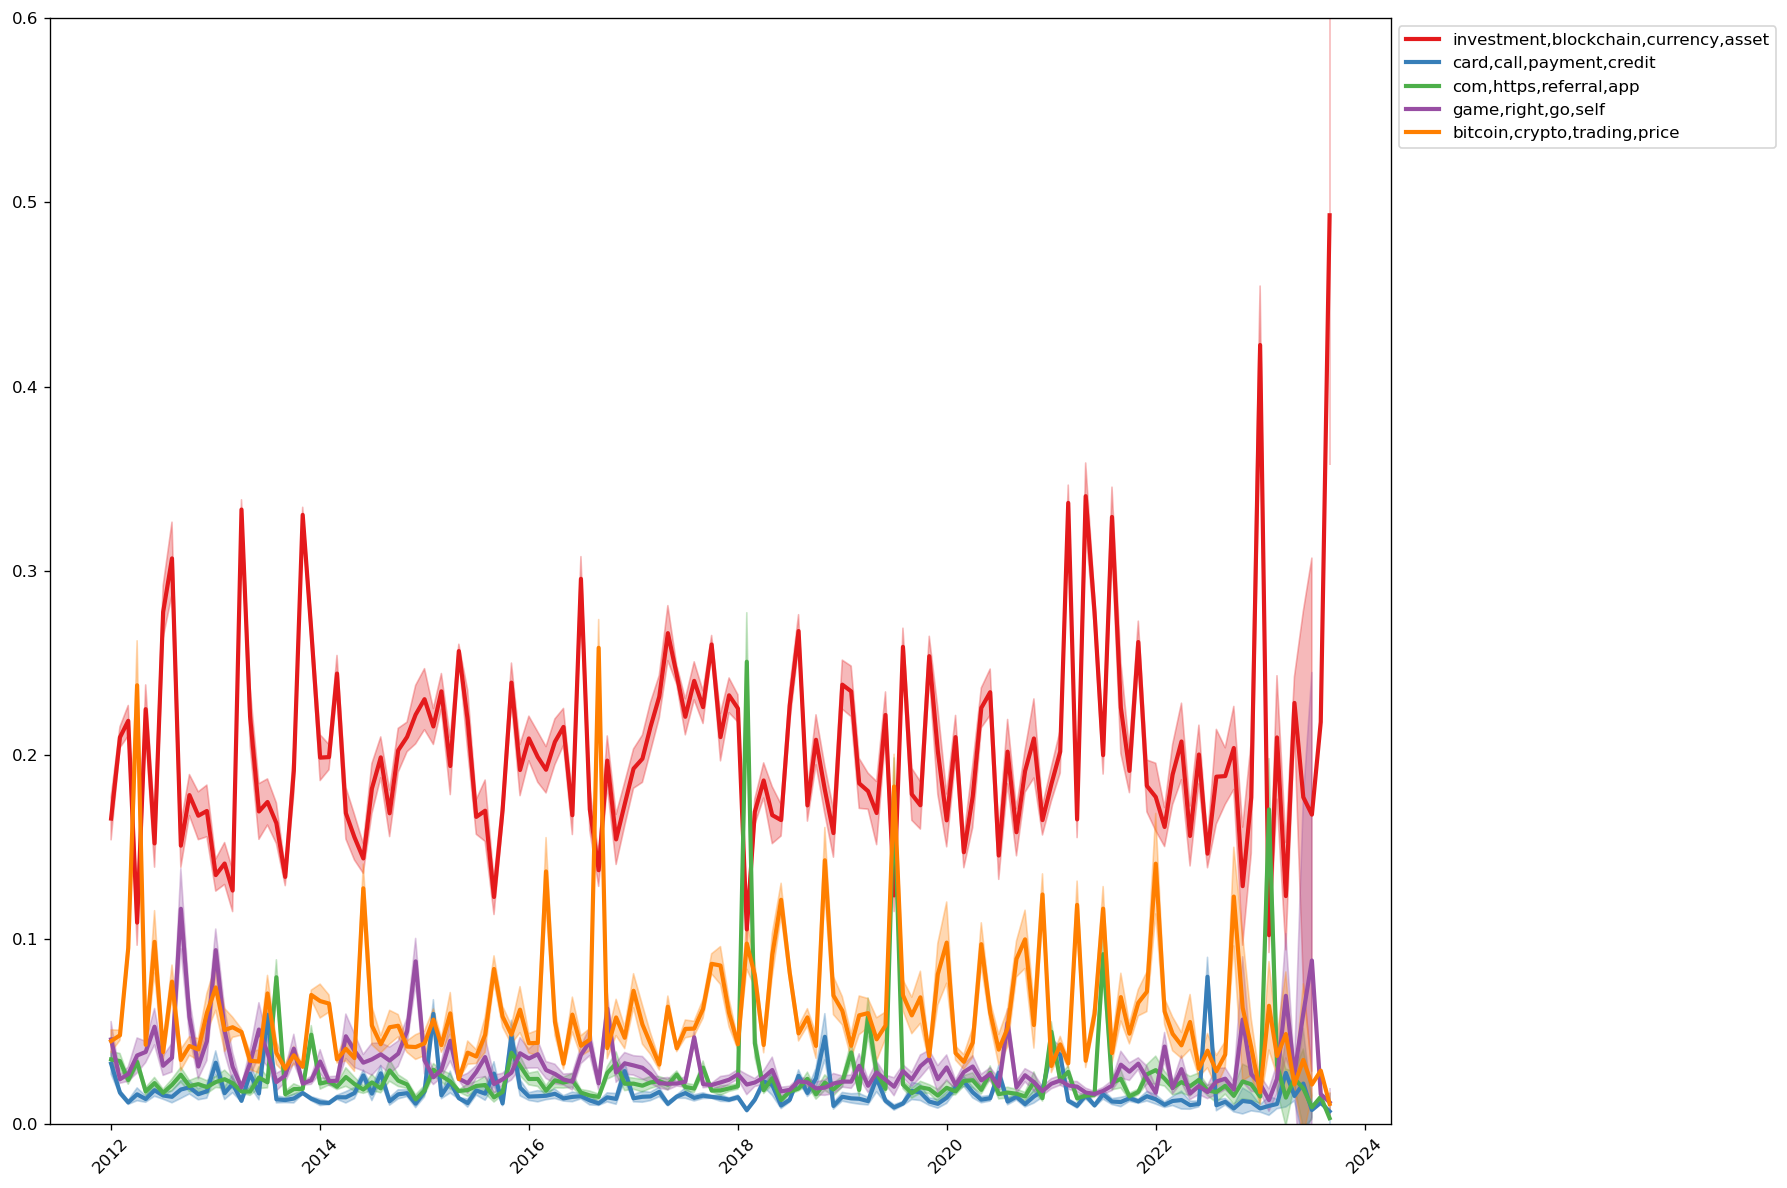

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

# Function to load data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['year-month'] = pd.to_datetime(data['year-month'])
    return data

# Function to calculate confidence interval
def calculate_confidence_interval(mean, std, n, confidence=0.95):
    h = std / np.sqrt(n) * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean - h, mean + h

# Function to plot data
def plot_data(data):
    # Select only the numeric columns for aggregation (excluding 'date')
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_numeric = data[numeric_columns]

    # Group by 'year-month' and calculate mean and standard deviation
    grouped_data = data_numeric.groupby(data['year-month']).agg(['mean', 'std'])
    grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]
    grouped_data.reset_index(inplace=True)

    # Calculate sample size for each month
    sample_sizes = data.groupby('year-month').size()

    # Calculate confidence intervals for each topic
    for column in numeric_columns:
        mean_name = column + '_mean'
        std_name = column + '_std'
        ci_lower_name = column + '_ci_lower'
        ci_upper_name = column + '_ci_upper'
        
        grouped_data[ci_lower_name], grouped_data[ci_upper_name] = zip(*grouped_data.apply(
            lambda row: calculate_confidence_interval(row[mean_name], row[std_name], sample_sizes[row.name]), axis=1))

    # Plotting
    plt.figure(figsize=(15, 10), dpi=120)
    colors = sns.color_palette("Set1", len(numeric_columns))  # Set1 color palette

    for idx, column in enumerate(numeric_columns):
        mean_name = column + '_mean'
        ci_lower_name = column + '_ci_lower'
        ci_upper_name = column + '_ci_upper'
        
        plt.plot(grouped_data['year-month'], grouped_data[mean_name], label=column, color=colors[idx], linewidth=2.5)  # Increased linewidth
        plt.fill_between(grouped_data['year-month'], grouped_data[ci_lower_name], grouped_data[ci_upper_name], color=colors[idx], alpha=0.3)
    '''
    plt.title('Mean Topic Proportion Over Time with Confidence Intervals')
    plt.xlabel('Year-Month')
    plt.ylabel('Mean Topic Proportion')
    '''
    plt.xticks(rotation=45)
    plt.ylim(0, 0.6)  # Set y-axis limit
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
    plt.grid(False)  # Remove grid
    plt.tight_layout()

    # Save the plot with a transparent background
    plt.savefig('topics.png', transparent=True)

    plt.show()

# Load data
file_path = 'topics.csv'  # Update with your file path
data = load_data(file_path)

# Plot data
plot_data(data)

